# Simple visualizations

Before getting into advanced visualizations such as [Buddhabrot](https://en.wikipedia.org/wiki/Buddhabrot), let's start simple.
Our goal for the moment will be to produce a black and white image of the Mandelbrot set.
Points belonging to the set will be shown in black and those outside in white.
The code below shows the algorithm students are most likely to come up with.

**<center>Algorithm 1: Nested `for` loops</center>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mandelbrot(c, maxiter=1000):
    # --> Boolean mask of the Mandelbrot set.
    #     Assume by default that all points are in the set.
    M = np.ones_like(c, dtype=bool)
    
    # --> Loop through the points in complex plane.
    m, n = c.shape
    
    for i in range(m):
        for j in range(n):
            
            # --> Initial condition.
            z = 0
            
            # --> Loop until | z | > 2.
            for k in range(maxiter):
                z = z**2 + c[i, j]
                
                # --> Check exit condition.
                if np.abs(z) > 2:
                    M[i, j] = False # c[i, j] not in the set.
                    break
    return M

The code is pretty simple.
It takes as input all the points used to discretize the complex plane (as a 2D array).
For each of them, it iterates the quadratic function for `maxiter` iterations.
If during this process $\vert z_k \vert > 2$, $c_{ij}$ does not belong to the Mandelbrot set.
If the iteration runs until `k = maxiter`, we'll assume for all intents and purposes that $c_{ij}$ is in the set (although it may not in reality but that may require a far larger number of iterations).

Let's now benchmark this first implementation.
We'll assume $c \in \left[-2.25, 0.75\right] \times \left[ -1.25i, 1.25i\right]$ and consider a relatively coarse discretization to begin with.
The real axis is discretized with 300 points the while imaginary one is discretized with 251 points.

In [3]:
# --> Mesh the complex plane.
cr, ci = np.linspace(-2.25, 0.75, 300), np.linspace(-1.25, 1.25, 251)
c = cr[:, None] + 1j*ci[None, :] # Broadcasting trick.

In [4]:
%%timeit
mandelbrot(c, maxiter=1000)

23.3 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my laptop, this computation takes a bit more than half a minute.
A high-resolution image of the Mandelbrot set typically uses ten times as many points in both directions compared to our low-resolution discretization.
This would incur approximately a 100 fold increase in computational time (i.e. more than one hour).
While this might be acceptable for a one-shot image, deep diving into the Mandelbrot set with thousands of images to generate is out of reach.

## Excluding points from the main cardioid

In **Algorithm 1**, we iterate the quadratic function for all the points discretizing the complex plane.
Yet, as shown in the previous section, we know analytically that some points actually belong to the Mandelbrot set.
In particular, we have analytical expressions to test whether $c$ is the main cardioid or in the period-2 bulb, both being parts of the Mandelbrot set.

**<center>Algorithm 2: Nested `for` loops + test for the main cardiod</center>**

In [5]:
def in_main_cardioid(c):
    q = (c.real - 1/4)**2 + c.imag**2
    return q*(q + (c.real -1/4)) <= c.imag**2 / 4
    
def in_period2bulb(c):
    return (c.real + 1)**2 + c.imag**2 <= 1/16

def mandelbrot(c, maxiter=1000):
    # --> Boolean mask of the Mandelbrot set.
    #     Assume by default that all points are in the set.
    M = np.ones_like(c, dtype=bool)
    
    # --> Loop through the points in complex plane.
    m, n = c.shape
    
    for i in range(m):
        for j in range(n):
            
            # --> Check if point is the main cardioid.
            if in_main_cardioid(c[i, j]): continue
            if in_period2bulb(c[i, j]): continue
            
            # --> Initial condition.
            z = 0
            
            # --> Loop until | z | > 2.
            for k in range(maxiter):
                z = z**2 + c[i, j]
                
                # --> Check exit condition.
                if np.abs(z) > 2:
                    M[i, j] = False # c[i, j] not in the set.
                    break
    return M

In [6]:
%%timeit
mandelbrot(c, maxiter=1000)

2.93 s ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The same computation now takes less than 5 seconds, a 7x speed-up compared to when we didn't check if $c$ belongs to the main cardioid.
If $c$ is not in the main cardioid, similar tests could be implemented to test if it instead belongs to some **period bulbs**.
This could also save us a few additional seconds to render the image.

## Vectorizing the code

Although we've achieved quite a significant speed-up, one major issue with our previous code is that it'll work only if the input `c` is a `np.array`.
Hence, we cannot use it to check if a particular value of $c$ is in the Mandelbrot set or not.
In `numpy`, a function that works both for a scalar or an array as input is known as a [universal function](https://numpy.org/doc/stable/reference/ufuncs.html), or **ufunc** in short.
`np.exp`, `np.cos` and others are all ufuncs.
A universal function is a function that operates on `np.array` in an element-by-element fashion.
It also supports broadcasting, type casting and several other standard `numpy` features.
To some extent, a ufunc can be understood as a "vectorized" wrapper for a function that takes a fixed number of specific inputs and produces a fixed number of specific outputs.

NumPy provides a simple utility, `np.vectorize`, to create user-defined ufuncs.
In what follows, we'll thus implement a function `mandelbrot` taking as input a single value of $c$ and returning whether it belongs to the Mandelbrot set or not.
We'll then make it work for array input using the decorator `@np.vectorize`.

**<center>Algorithm 3: Cleaner code with `@np.vectorize`</center>**

In [7]:
@np.vectorize
def mandelbrot(c, maxiter=1000):

    if in_main_cardioid(c): return True
    if in_period2bulb(c): return True

    z = 0
    for i in range(maxiter):
        z = z**2 + c
        if np.abs(z) > 2:
            return False
    return True

As you can see, this new piece of code is now much cleaner than our previous implementation.
We did not really get rid of the first two nested `for` loops though.
They are somehow hidden in the magic numpy is doing to transform our function.
Yet, it is now more general as it'll accept both scalar values and arrays as input.
Let's benchmark it.

In [8]:
%%timeit
mandelbrot(c, maxiter=1000)

2.05 s ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The code now takes only 3 seconds to execute, another 2x speed-up!
Despite what the name `np.vectorize` suggests, our function is not truly vectorized.
It still operates on an element-wise fashion rather than on the whole array at once.
The small speed-up essentially comes from tricks used by the NumPy developers.
In comparison, the code below shows what a truly vectorized implementation looks like.
Its drawback however is that it can only operate on arrays and not scalar values.

**<center>Algorithm 4: True vectorization in `numpy`</center>**

In [9]:
def mandelbrot(c, maxiter=1000):
    # --> Boolean mask of the Mandelbrot set.
    #     Assume of all points are in the set by default.
    M = np.ones_like(c, dtype=bool)
    
    # --> Vectorized initial condition.
    z = np.zeros_like(c, dtype=complex)
    
    for i in range(maxiter):
        # --> Iterate.
        z[M] = z[M]**2 + c[M]
        
        # --> Check escape condition.
        #     Escaped points are no longer iterated.
        M[np.abs(z) > 2] = False
        
    return M

In [10]:
%%timeit
mandelbrot(c, maxiter=1000)

224 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The true vectorized implementation (without the test for the cardioid and period-2 bulb) is 2 times faster than the one obtained from `np.vectorize`.
Had we considered the test for the main cardioid, it would have been even faster even though we would have had to play a bit with boolean logic on arrays.

## JIT implementation with `numba`

Computing the Mandelbrot set essentially involves nested `for` loops.
Yet, `for` loops are terribly inefficient in pure Python.
In these cases, Python's scientific computing ecosystem has a few extremely useful packages.
One of them is [**Numba**](https://numba.pydata.org/), an open source *just-in-time* compiler that can translate a subset of Python or NumPy code into fast machine code.
From Numba's website

> Numba translates Python functions to optimized machine code at runtime using the industry-standard [LLVM](https://llvm.org/) compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or Fortran.

What Numba does basically is to take your naïve Python implementation and generates on-the-fly specialized machine code for different array data types and layouts to optimize performance.

```{admonition} Be careful though...
:class: danger
At first, Numba may seem kind of magic and you may be tempted to use it on all your different pieces of code.
It may not however bring the speed-up you expected it would!
For more details about when to use or not Numba JIT capabilities, please read [Numba's documentation](https://numba.readthedocs.io/en/stable/user/5minguide.html).
```

Despite what we've just said, our function `mandelbrot` is luckily an excellent candidate to illustrate the massive speed-up Numba can bring.
After having imported `numba`, using its JIT capabilities is as simple as adding the decorator `@numba.jit()` to your function.
To create a **ufunc**, you can use the `@numba.vectorize` decorator.
This is illustrated below.

**<center>Algorithm 5: Universal function with `numba.vectorize`</center>**

In [11]:
import numba

@numba.jit(nopython=True)
def in_main_cardioid(c):
    q = (c.real - 1/4)**2 + c.imag**2
    return q*(q + (c.real - 1/4)) <= c.imag**2/4

@numba.jit(nopython=True)
def in_period2bulb(c):
    return (c.real + 1)**2 + c.imag**2 <= 1/16

@numba.vectorize(nopython=True)
def mandelbrot(c, maxiter):
    # --> Check if point is in main cardioid.
    if in_main_cardioid(c): return True
    if in_period2bulb(c): return True
    
    # --> If not, check if it is nonetheless in the
    #     Mandelbrot set.
    z = 0
    for i in range(maxiter):
        if np.abs(z) > 2:
            return False
        z = z**2 + c

    return True

In [12]:
%%timeit
mandelbrot(c, 1000)

11.7 ms ± 69.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


One limitation of ufuncs generated with `numba` is that they do not accept optional arguments (although you can hack you way into it).
You have to pass all of the arguments.
In all respect, this is a fairly small price given that our code now runs in 20 milliseconds, a whooping 1700x speed-up compared to our original implementation!
As you increase the resolution, this speed-up will get even larger.

Now that we have achieved a more than significant speed-up compared to our original implementation using fairly simple programming techniques, we can start to think about further optimizing the code.
In particular, we can get rid of complex arithmetic and transform everything into real one.
Moreover, there are some redundant multiplications we can get rid of.
The code below does just that.

**<center>Algorithm 6: Further optimizations</center>**

In [13]:
@numba.vectorize(nopython=True)
def mandelbrot(c, maxiter):
    # --> Check if point is in main cardioid.
    if in_main_cardioid(c): return True
    if in_period2bulb(c): return True
    
    # --> If not, check if it is nonetheless in the
    #     Mandelbrot set.
    x, y = c.real, c.imag
    x2, y2 = x*x, y*y
    for i in range(maxiter):
        if (x2 + y2) > 4:
            return False
            
        y = 2*x*y + c.imag
        x = x2 - y2 + c.real
        x2, y2 = x*x, y*y

    return True

In [14]:
%%timeit
mandelbrot(c, 1000)

4.87 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Using this optimized code gives us an additional 2-3x speed-up, or a grand total of almost 4000x speed-up compared to the pure Python code.
As an exercise, try to figure out why writing the code this way is faster than the one provided in Algorithm 5.

**Optimizing a code**

When it comes to optimizing a code, particularly in terms of operations count, remember famous computer scientist [Donal Knuth](https://en.wikipedia.org/wiki/Donald_Knuth)

> Premature optimization is the root of all evil.

Such optimizations should really come only once you've already exhausted all the possibilities offered by simpler programming techniques.
Moreover, you should not try to optimize your whole code.
That would rapidly be a waste of time!
Instead, first come up with a fairly simple yet efficient implementation.
Then, try to identify the most important bottlenecks and optimize only these, not the rest of the code.
This will be a better use of your limited time!

## Black and white visualization

We are now ready to generate our first high-resolution image of the Mandelbrot set.
We'll once again consider $c \in \left[-2.25, 0.75\right] \times \left[ -1.25i, 1.25i\right]$.
The real axis will now be discretized using 3000 points, while the imaginary one is discretized with 2501 points.
For each point (provided it is not in the main cardioid), the quadratic function will be iterated up to 1000 times to check whether the point is in the Mandelbrot set or not.
The code is shown in the cell below (you can toggle it).
The `matplotlib` code used to generate the image is fairly simple and won't be discussed.
We could also have used `PIL` instead, another Python package for images.

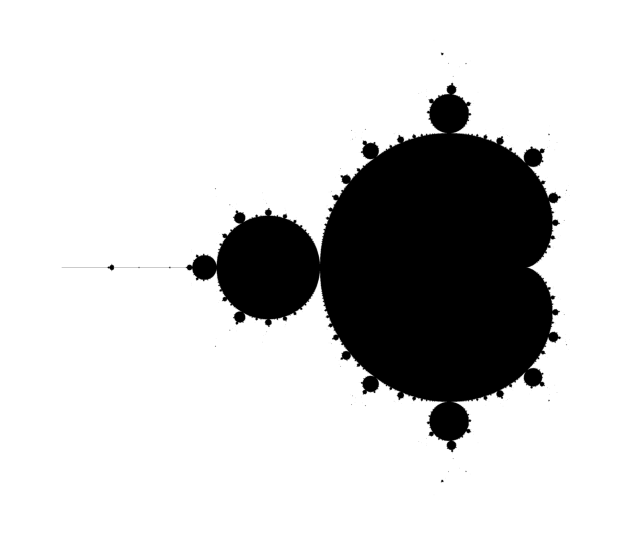

In [15]:
# --> Mesh the complex plane.
cr, ci = np.linspace(-2.25, 0.75, 3000), np.linspace(-1.25, 1.25, 2501)
c = cr[:, None] + 1j*ci[None, :] # Broadcasting trick.

# --> Get points in/out the Mandelbrot set.
M = mandelbrot(c, 1000)

def plot(M, extent=[-2.25, 0.75, -1.25, 1.25]):

    # --> Simple binary visualization.
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.imshow(
        M.T, 
        extent=extent,
        cmap=plt.cm.binary)

    ax.set_aspect("equal")
    ax.axis(False);
    
plot(M)

## Adding some colours

I remember pretty clearly the first time I generated this black and white image of the Mandelbrot set as a student.
My code probably involved a bunch of nested `for` loops and was written in MATLAB or SciLab.
It was slow. Painfully slow.
Yet, it gave me immense joy.
YouTube was not yet a thing, and I found out only a couple of years later about all the crazy way you could use to render the Mandelbrot set.
So let's add some colours to our image!

Until now, our piece of code only gives a yes-no answer.
Either the point is in the Mandelbrot set and the corresponding pixel is colored in black, or it is not and the pixel is colored in white.
The **escape time algorithm** is the second simplest method to render the Mandelbrot set and gives us more nuance.
Rather than simply having this yes-no answer, we'll keep track of how many iterations were needed to escape if $c$ is not part of the Mandelbrot set and color the pixel accordingly using any colormap you want.
This requires very little modification of our original code.

**<center>Escape time algorithm</center>**

In [16]:
@numba.vectorize(nopython=True)
def mandelbrot(c, maxiter):
    # --> Check if point is in main cardioid.
    if in_main_cardioid(c): return maxiter
    if in_period2bulb(c): return maxiter
    
    # --> If not, check if it is nonetheless in the
    #     Mandelbrot set.
    x, y = c.real, c.imag
    x2, y2 = x*x, y*y
    for i in range(maxiter):
        if (x2 + y2) > 4:
            return i
            
        y = 2*x*y + c.imag
        x = x2 - y2 + c.real
        x2, y2 = x*x, y*y

    return maxiter

That's it! Literally! The escape time algorithm is as simple as replacing the `True`/`False` return with the number of iterations it took to escape.
Let's now render some Mandelbrot sets.
We'll use colormaps from the `cmasher` package.
Check out its [webpage](https://cmasher.readthedocs.io/index.html) if you want to install it.

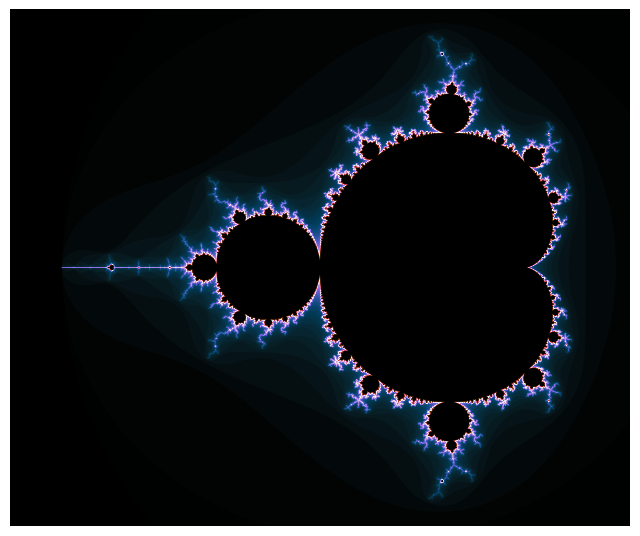

In [17]:
import matplotlib.pyplot as plt
import cmasher as cmr

# --> Mesh the complex plane.
cr, ci = np.linspace(-2.25, 0.75, 3000), np.linspace(-1.25, 1.25, 2501)
c = cr[:, None] + 1j*ci[None, :] # Broadcasting trick.

# --> Get points in/out the Mandelbrot set.
M = mandelbrot(c, 100)

def plot(M, extent=[-2.25, 0.75, -1.25, 1.25]):

    # --> Simple binary visualization.
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.imshow(
        M.T, 
        extent=extent,
        cmap="cmr.emergency")

    ax.set_aspect("equal")
    ax.axis(False);
    
plot(M)

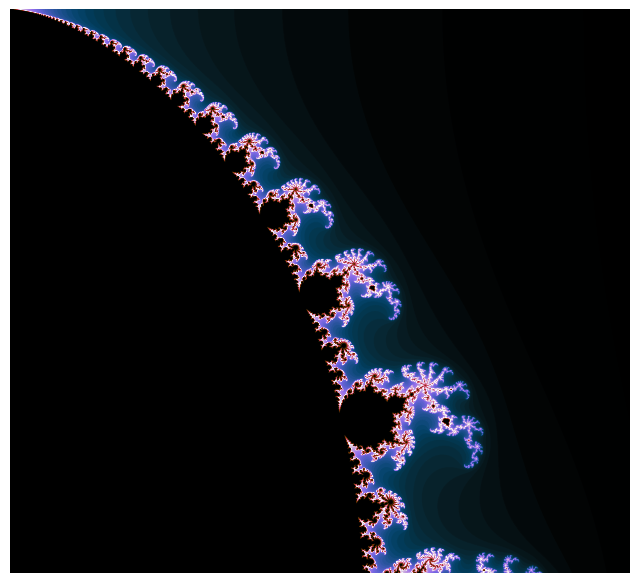

In [18]:
cr, ci = np.linspace(0.26-0.01, 0.26+0.21, 3000), np.linspace(0, 0.2, 3000)
c = cr[:, None] + 1j*ci[None, :] # Broadcasting trick.

M = mandelbrot(c, 100)

plot(M, extent=[cr.min(), cr.max(), ci.min(), ci.max()])